# 라이브러리

In [2]:
from ultralytics import YOLO
import mediapipe as mp
import cv2
import torch
import numpy as np
import glob
import pandas as pd
from tensorflow import keras
from keras.models import load_model

# 배경 이미지

In [2]:
folder_path = './data/background'  # 폴더 경로 설정
file_list = glob.glob(folder_path + '/*')  # 폴더 내의 파일 목록 얻기
file_count = len(file_list)  # 파일 개수 계산
print(f"폴더 내 파일 개수: {file_count}")

폴더 내 파일 개수: 14


In [ ]:
# 파일 리스트를 적절히 초기화해야 함
idx = 0

while True:
    bgimg = cv2.imread(file_list[idx])
    cv2.imshow('test', bgimg)
    
    key = cv2.waitKey(0)  # 키 입력 대기
    
    if key == ord('c'):
        idx += 1
        if idx >= len(file_list):
            idx = 0
    elif key == ord('z'):
        idx -= 1
        if idx < 0:
            idx = len(file_list) - 1
    elif key == ord('q'):
        break

cv2.destroyAllWindows()



In [3]:
# YOLOv8 모델 로드
model = YOLO('yolov8n-seg.pt')

# 웹캠을 위한 비디오 캡처 객체 열기
cap = cv2.VideoCapture(0)

# 적용할 배경
# bgimg = cv2.imread('./yolobg.jpg')

# 비디오 프레임을 반복하여 처리
while cap.isOpened():
    # 비디오에서 프레임 읽기
    success, frame = cap.read()

    if success:
        # YOLOv8를 사용하여 프레임에 대한 추론 실행 
        # classes를 통해 사람만 탐지하도록 설정
        results = model(frame, classes=0)

        # 검정색 배경 이미지 생성
        background = np.zeros(frame.shape, dtype=np.uint8)

        for result in results:
            # print(result)
            for mask in result.masks:
                # 마스크 데이터에서 차원 축소
                m = torch.squeeze(mask.data)
                # 마스크를 RGB 형식으로 변환하여 컴포지트(composite) 텐서 생성
                composite = torch.stack((m, m, m), 2)
                # 프레임과 컴포지트를 곱하여 마스크 영역 추출
                tmp = frame * composite.cpu().numpy().astype(np.uint8)
                # 추출된 마스크 영역을 배경에 누적
                background += tmp

        # 배경 이미지를 원하는 배경으로 마스킹
        bgimg_resized = cv2.resize(bgimg, (frame.shape[1], frame.shape[0]))
        background = np.where(background == 0, bgimg_resized, background)

        # 마스킹된 이미지 출력
        cv2.imshow("웹캠 배경 마스킹", background)

        # 'q' 키가 눌리면 루프 종료
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    else:
        # 비디오의 끝에 도달하면 루프 종료
        break

# 비디오 캡처 객체 해제 및 화면 창 닫기
cap.release()
cv2.destroyAllWindows()



0: 480x640 1 person, 94.9ms
Speed: 4.0ms preprocess, 94.9ms inference, 403.5ms postprocess per image at shape (1, 3, 480, 640)


NameError: name 'bgimg' is not defined

In [4]:
# 비디오 캡처 객체 해제 및 화면 창 닫기
cap.release()
cv2.destroyAllWindows()

- 사람이외에 학습된 객체 탐지를 발견
- if문을 통해 사람만 마스킹해보려하였으나 실패
>* ex)result.boxes.cls == 0
- 홈페이지에서 탐지 객체를 지정하는 옵션을 발견해 적용

## yolov8에서 탐지가능한 객체 딕셔너리

In [13]:
# 0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 
# 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light',
# 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 
# 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 
# 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 
# 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 
# 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 
# 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle',
# 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon',
# 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange',
# 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut',
# 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed',
# 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse',
# 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven',
# 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock',
# 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'

# 0: '사람', 1: '자전거', 2: '자동차', 3: '오토바이', 4: '비행기',
# 5: '버스', 6: '기차', 7: '트럭', 8: '보트', 9: '신호등',
# 10: '소화전', 11: '정지 신호', 12: '주차 미터', 13: '벤치', 14: '새',
# 15: '고양이', 16: '개', 17: '말', 18: '양', 19: '소',
# 20: '코끼리', 21: '곰', 22: '얼룩말', 23: '기린', 24: '배낭',
# 25: '우산', 26: '핸드백', 27: '넥타이', 28: '여행가방', 29: '프리스비',
# 30: '스키', 31: '스노보드', 32: '스포츠 공', 33: '연', 34: '야구 방망이',
# 35: '야구 글러브', 36: '스케이트보드', 37: '서프보드', 38: '테니스 라켓', 39: '병',
# 40: '와인 잔', 41: '컵', 42: '포크', 43: '칼', 44: '숟가락',
# 45: '그릇', 46: '바나나', 47: '사과', 48: '샌드위치', 49: '오렌지',
# 50: '브로콜리', 51: '당근', 52: '핫도그', 53: '피자', 54: '도넛',
# 55: '케이크', 56: '의자', 57: '소파', 58: '화분', 59: '침대',
# 60: '식탁', 61: '화장실', 62: 'TV', 63: '노트북', 64: '마우스',
# 65: '리모컨', 66: '키보드', 67: '휴대폰', 68: '전자레인지', 69: '오븐',
# 70: '토스터', 71: '싱크대', 72: '냉장고', 73: '책', 74: '시계',
# 75: '꽃병', 76: '가위', 77: '테디 베어', 78: '헤어 드라이어', 79: '칫솔'

In [ ]:
#  0: 'person'            ->      0: '사람'
#  1: 'bicycle'           ->      1: '자전거'
#  2: 'car'               ->      2: '자동차'
#  3: 'motorcycle'        ->      3: '오토바이'
#  4: 'airplane'          ->      4: '비행기'
#  5: 'bus'               ->      5: '버스'
#  6: 'train'             ->      6: '기차'
#  7: 'truck'             ->      7: '트럭'
#  8: 'boat'              ->      8: '보트'
#  9: 'traffic light'     ->      9: '신호등'
# 10: 'fire hydrant'      ->     10: '소화전'
# 11: 'stop sign'         ->     11: '정지 신호'
# 12: 'parking meter'     ->     12: '주차 미터'
# 13: 'bench'             ->     13: '벤치'
# 14: 'bird'              ->     14: '새'
# 15: 'cat'               ->     15: '고양이'
# 16: 'dog'               ->     16: '개'
# 17: 'horse'             ->     17: '말'
# 18: 'sheep'             ->     18: '양'
# 19: 'cow'               ->     19: '소'
# 20: 'elephant'          ->     20: '코끼리'
# 21: 'bear'              ->     21: '곰'
# 22: 'zebra'             ->     22: '얼룩말'
# 23: 'giraffe'           ->     23: '기린'
# 24: 'backpack'          ->     24: '배낭'
# 25: 'umbrella'          ->     25: '우산'
# 26: 'handbag'           ->     26: '핸드백'
# 27: 'tie'               ->     27: '넥타이'
# 28: 'suitcase'          ->     28: '여행가방'
# 29: 'frisbee'           ->     29: '프리스비'
# 30: 'skis'              ->     30: '스키'
# 31: 'snowboard'         ->     31: '스노보드'
# 32: 'sports ball'       ->     32: '스포츠 공'
# 33: 'kite'              ->     33: '연'
# 34: 'baseball bat'      ->     34: '야구 방망이'
# 35: 'baseball glove'    ->     35: '야구 글러브'
# 36: 'skateboard'        ->     36: '스케이트보드'
# 37: 'surfboard'         ->     37: '서프보드'
# 38: 'tennis racket'     ->     38: '테니스 라켓'
# 39: 'bottle'            ->     39: '병'
# 40: 'wine glass'        ->     40: '와인 잔'
# 41: 'cup'               ->     41: '컵'
# 42: 'fork'              ->     42: '포크'
# 43: 'knife'             ->     43: '칼'
# 44: 'spoon'             ->     44: '숟가락'
# 45: 'bowl'              ->     45: '그릇'
# 46: 'banana'            ->     46: '바나나'
# 47: 'apple'             ->     47: '사과'
# 48: 'sandwich'          ->     48: '샌드위치'
# 49: 'orange'            ->     49: '오렌지'
# 50: 'broccoli'          ->     50: '브로콜리'
# 51: 'carrot'            ->     51: '당근'
# 52: 'hot dog'           ->     52: '핫도그'
# 53: 'pizza'             ->     53: '피자'
# 54: 'donut'             ->     54: '도넛'
# 55: 'cake'              ->     55: '케이크'
# 56: 'chair'             ->     56: '의자'
# 57: 'couch'             ->     57: '소파'
# 58: 'potted plant'      ->     58: '화분'
# 59: 'bed'               ->     59: '침대'
# 60: 'dining table'      ->     60: '식탁'
# 61: 'toilet'            ->     61: '화장실'
# 62: 'tv'                ->     62: 'TV'
# 63: 'laptop'            ->     63: '노트북'
# 64: 'mouse'             ->     64: '마우스'
# 65: 'remote'            ->     65: '리모컨'
# 66: 'keyboard'          ->     66: '키보드'
# 67: 'cell phone'        ->     67: '휴대폰'
# 68: 'microwave'         ->     68: '전자레인지'
# 69: 'oven'              ->     69: '오븐'
# 70: 'toaster'           ->     70: '토스터'
# 71: 'sink'              ->     71: '싱크대'
# 72: 'refrigerator'      ->     72: '냉장고'
# 73: 'book'              ->     73: '책'
# 74: 'clock'             ->     74: '시계'
# 75: 'vase'              ->     75: '꽃병'
# 76: 'scissors'          ->     76: '가위'
# 77: 'teddy bear'        ->     77: '테디 베어'
# 78: 'hair drier'        ->     78: '헤어 드라이어'
# 79: 'toothbrush'        ->     79: '칫솔'

# 배경 변경버전

In [1]:
from ultralytics import YOLO
import cv2
import torch
import numpy as np
import glob
import pandas as pd

In [3]:
import cv2
from ultralytics import YOLO

# Load a pretrained YOLOv8n model
model = YOLO('yolov8n.pt')

# Read an image using OpenCV
source = cv2.imread('../BAX_HTP/data/dbi/24_175_23002_person.jpg')

# Run inference on the source
results = model(source)  # list of Results objects



0: 480x640 1 kite, 2 clocks, 53.0ms
Speed: 4.0ms preprocess, 53.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


In [5]:
cv2.imshow('d', results)
cv2.waitKey(0)
cv2.destroyAllWindows()

error: OpenCV(4.8.0) :-1: error: (-5:Bad argument) in function 'imshow'
> Overload resolution failed:
>  - mat is not a numpy array, neither a scalar
>  - Expected Ptr<cv::cuda::GpuMat> for argument 'mat'
>  - Expected Ptr<cv::UMat> for argument 'mat'


In [2]:
# YOLOv8 모델 로드
model = YOLO('yolov8s-seg.pt')

# 웹캠을 위한 비디오 캡처 객체 열기
cap = cv2.VideoCapture(0)

# 배경을 불러오기
folder_path = './data/background'  # 폴더 경로 설정
file_list = glob.glob(folder_path + '/*')  # 폴더 내의 파일 목록 얻기
file_count = len(file_list)  # 파일 개수 계산
idx = 0 # 파일 리스트를 적절히 초기화해야 함

# 비디오 프레임을 반복하여 처리
while cap.isOpened():
    # 비디오에서 프레임 읽기
    success, frame = cap.read()

    if success:
        # YOLOv8를 사용하여 프레임에 대한 추론 실행
        # classes를 통해 사람만 탐지하도록 설정
        results = model(frame, classes=0)
        # 검정색 배경 이미지 생성
        background = np.zeros(frame.shape, dtype=np.uint8)
        
        try: # 사람이 탐지되지않으면 오류나는것을 방지
            for result in results:
                # print(result.names) # 탐지 객체 목록 딕셔너리
                # if result.boxes.conf >= 0.80:
                    # print(result.boxes.conf)
                    # if result.probs is not None and result.probs.top1 == 1:
                    for mask in result.masks:
                        # 마스크 데이터에서 차원 축소
                        m = torch.squeeze(mask.data)
                        # 마스크를 RGB 형식으로 변환하여 컴포지트(composite) 텐서 생성
                        composite = torch.stack((m, m, m), 2)
                        # 프레임과 컴포지트를 곱하여 마스크 영역 추출
                        tmp = frame * composite.cpu().numpy().astype(np.uint8)
                        # 추출된 마스크 영역을 배경에 누적
                        # 미리 생성해둔 검은 배경에 세그먼트된 영역을 채워넣음
                        background += tmp
                # else:
                #     # results = model(frame, classes=0)

        except:
            pass

        # 배경 이미지를 원하는 배경으로 마스킹
        bgimg = cv2.imread(file_list[idx])
        bgimg_resized = cv2.resize(bgimg, (frame.shape[1], frame.shape[0]))
        # 검정색배경에 세그먼트된 영상에서 0인값을 설정해둔 배경으로 마스킹
        background = np.where(background == 0, bgimg_resized, background)
        background = cv2.resize(background, (960,720))
        # 마스킹된 이미지 출력
        cv2.imshow("Project", cv2.flip(background, 1)) # 좌우반전

        key = cv2.waitKey(1)
        # 'q', 'esc', x버튼 키가 눌리면 루프 종료
        if key == 113 or key == 27 or cv2.getWindowProperty('Project', cv2.WND_PROP_VISIBLE) < 1: # ord("q")
            break
        # 'c' 키가 눌리면 다음 배경
        elif key == 99: # ord("c")
            idx += 1
            if idx >= len(file_list):
                idx = 0
        # 'z' 키가 눌리면 이전 배경
        elif key == 122: # ord("z")
            idx -= 1
            if idx < 0:
                idx = len(file_list) - 1

    else:
        # 비디오의 끝에 도달하면 루프 종료
        break

# 비디오 캡처 객체 해제 및 화면 창 닫기
cap.release()
cv2.destroyAllWindows()


WARNING  NMS time limit 0.550s exceeded
0: 480x640 1 person, 93.1ms
Speed: 5.0ms preprocess, 93.1ms inference, 729.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 12.0ms
Speed: 2.0ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 11.0ms
Speed: 1.0ms preprocess, 11.0ms inference, 2.0ms post

In [44]:
cap.release()
cv2.destroyAllWindows()

# 추가 개선 방안

* 모션인식을 통한 배경 변경 예시) 오른쪽으로 손을 슬라이드하면 다음 배경 왼쪽 이전 배경
* 추가 필터 효과
* 스팀 프로필 효과같은것
* 검출된 객체의 엣지를 배경색상과 비슷하게 처리

In [3]:
# YOLOv8 모델 로드
model = YOLO('yolov8s-seg.pt')

# 웹캠을 위한 비디오 캡처 객체 열기
cap = cv2.VideoCapture(0)

# 배경을 불러오기
folder_path = './data/background'  # 폴더 경로 설정
file_list = glob.glob(folder_path + '/*')  # 폴더 내의 파일 목록 얻기
file_count = len(file_list)  # 파일 개수 계산
idx = 0 # 파일 리스트를 적절히 초기화해야 함

# 비디오 프레임을 반복하여 처리
while cap.isOpened():
    # 비디오에서 프레임 읽기
    success, frame = cap.read()

    if success:
        # YOLOv8를 사용하여 프레임에 대한 추론 실행
        # classes를 통해 사람만 탐지하도록 설정
        results = model(frame, classes=0)
        # 검정색 배경 이미지 생성
        background = np.zeros(frame.shape, dtype=np.uint8)
        
        try: # 사람이 탐지되지않으면 오류나는것을 방지
            for result in results:
                # print(result.names) # 탐지 객체 목록 딕셔너리
                # if result.boxes.conf >= 0.80:
                    # print(result.boxes.conf)
                    # if result.probs is not None and result.probs.top1 == 1:
                    for mask in result.masks:
                        # 마스크 데이터에서 차원 축소
                        m = torch.squeeze(mask.data)
                        # 마스크를 RGB 형식으로 변환하여 컴포지트(composite) 텐서 생성
                        composite = torch.stack((m, m, m), 2)
                        # 프레임과 컴포지트를 곱하여 마스크 영역 추출
                        tmp = frame * composite.cpu().numpy().astype(np.uint8)
                        # 추출된 마스크 영역을 배경에 누적
                        background += tmp
                # else:
                #     # results = model(frame, classes=0)

        except:
            pass

        # 배경 이미지를 원하는 배경으로 마스킹
        bgimg = cv2.imread(file_list[idx])
        bgimg_resized = cv2.resize(bgimg, (frame.shape[1], frame.shape[0]))
        # 엣지 부분을 블러 처리하여 배경과 자연스럽게 통합
        edges = cv2.Canny(background, 500, 500)  # 엣지 추출
        blurred_edges = cv2.GaussianBlur(edges, (9, 9), 0)  # 엣지 블러 처리
        # 엣지 부분을 검정색으로 처리
        # background[blurred_edges != 0] = 255
        # 배경과 마스킹된 이미지를 합성
        # composite_img = cv2.add(background, bgimg_resized)
        background = np.where(background == 0, bgimg_resized, background)
        # 마스킹된 이미지 출력
        # cv2.imshow("Project", cv2.flip(composite_img, 1))

        # 마스킹된 이미지 출력
        cv2.imshow("Project", cv2.flip(background, 1)) # 좌우반전

        key = cv2.waitKey(1)
        # 'q', 'esc', x버튼 키가 눌리면 루프 종료
        if key == 113 or key == 27 or cv2.getWindowProperty('Project', cv2.WND_PROP_VISIBLE) < 1: # ord("q")
            break
        # 'c' 키가 눌리면 다음 배경
        elif key == 99: # ord("c")
            idx += 1
            if idx >= len(file_list):
                idx = 0
        # 'z' 키가 눌리면 이전 배경
        elif key == 122: # ord("z")
            idx -= 1
            if idx < 0:
                idx = len(file_list) - 1

    else:
        # 비디오의 끝에 도달하면 루프 종료
        break

# 비디오 캡처 객체 해제 및 화면 창 닫기
cap.release()
cv2.destroyAllWindows()


0: 480x640 2 persons, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 8.0ms
Speed: 1.0ms preprocess, 8.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 13.0ms
Speed: 2.3ms preprocess, 13.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 2 persons, 7.0ms
Speed: 1.0ms preprocess, 7.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640

# 모션인식을 위한 코드

### 데이터셋 생성

In [24]:
import cv2
import mediapipe as mp
import numpy as np
import time, os

# 학습시킬 데이터 지정
actions = ['Next', 'Preview', 'Cam_Off', 'Cam_On']
seq_length = 30 # window의 사이즈
secs_for_action = 30 # 하나의 제스쳐를 찍는데 걸리는 시간

# MediaPipe hands model

# 초기화
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    max_num_hands = 1, # 몇 개의 손을 인식할 것인지
    min_detection_confidence = 0.5,
    min_tracking_confidence = 0.5)

# 웹캠 열기
cap = cv2.VideoCapture(0)
dirpath = './data/Mini_Project/motion/'
created_time = int(time.time())
os.makedirs(dirpath+'dataset', exist_ok=True) # 데이터 셋을 저장할 폴더 만들기

# 웹캠을 열어서 데이터 모으기
while cap.isOpened():
    for idx, action in enumerate(actions):
        data = []

        # 이미지 읽기
        ret, img = cap.read()

        # flip, 웹캠 이미지가 거울처럼 나타나기 때문
        img = cv2.flip(img, 1)

        # 어떤 제스쳐를 학습시킬 것인지 표시
        cv2.putText(img, f'Waiting for collecting {action.upper()} action...', org=(10,30),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(255,255,255), thickness=2)
        
        #3초동안 대기
        cv2.imshow('img', img)
        cv2.waitKey(3000)

        start_time = time.time()
        
        #30초동안 촬영
        while time.time() - start_time < secs_for_action:
            ret, img = cap.read()

            img = cv2.flip(img, 1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # opencv는 기본적으로 BGR로 영상을 읽기 때문에 RGB로 바꿔야 함
            result = hands.process(img) # RGB로 바꾼 데이터를 result에 저장
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            if result.multi_hand_landmarks is not None:
                for res in result.multi_hand_landmarks:
                    joint = np.zeros((21,4))
                    for j,lm in enumerate(res.landmark):
                        joint[j] = [lm.x, lm.y, lm.z, lm.visibility] # 각 점의 x, y, z 좌표 & 점이 이미지 상에서 보이는지 안 보이는지

                    # 점들 간의 각도 계산하기
                    v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
                    v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
                    v = v2 - v1 # v2와 v1 사이의 벡터 구하기

                    # 벡터 정규화 시키기(단위 벡터 구하기)
                    v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

                    # 점곱을 구한 다음 arccos으로 각도 구하기
                    angle = np.arccos(np.einsum('nt,nt->n',
                        v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                        v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

                    angle = np.degrees(angle) # 라디안을 각도로 바꾸기

                    angle_label = np.array([angle], dtype=np.float32)
                    angle_label = np.append(angle_label, idx) # 라벨 추가

                    d = np.concatenate([joint.flatten(), angle_label])

                    data.append(d)

                    mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS) # 랜드마크 그리기
            
            cv2.imshow('img', img)
            if cv2.waitKey(1) == ord('q'):
                break

        data = np.array(data)
        print(action, data.shape)
        np.save(os.path.join(dirpath+'dataset', f'raw_{action}_{created_time}'),data)

        # 시퀀스 데이터로 변환
        full_seq_data = []
        for seq in range(len(data) - seq_length):
            full_seq_data.append(data[seq:seq + seq_length])

        full_seq_data = np.array(full_seq_data)
        print(action, full_seq_data.shape)
        np.save(os.path.join(dirpath+'dataset', f'seq_{action}_{created_time}'), full_seq_data)
    break

cap.release()
cv2.destroyAllWindows()

Next (109, 100)
Next (79, 30, 100)
Preview (130, 100)
Preview (100, 30, 100)
Cam_Off (155, 100)
Cam_Off (125, 30, 100)
Cam_On (168, 100)
Cam_On (138, 30, 100)


# 학습

In [32]:
import os
import numpy as np
from tensorflow import keras
from keras.utils import to_categorical

folder_path = './data/Mini_Project/motion/dataset/'

actions = ['Next', 'Preview', 'Cam_Off', 'Cam_On']

# "seq"가 포함된 파일 리스트를 가져옵니다.
file_list = [file for file in os.listdir(folder_path) if 'seq' in file] 
# actions 리스트 순서대로 정렬
file_list.sort(key=lambda x: [actions.index(a) for a in actions if a in x]) 

sequences = []
for file_name in file_list:
    file_path = os.path.join(folder_path, file_name)
    sequence = np.load(file_path)
    sequences.append(sequence)

data = np.concatenate(sequences, axis=0)
print(file_list)
print(data.shape)

['seq_Next_1689234345.npy', 'seq_Preview_1689234345.npy', 'seq_Cam_Off_1689234345.npy', 'seq_Cam_On_1689234345.npy']
(442, 30, 100)


In [ ]:
# import numpy as np
# from tensorflow import keras
# from keras.utils import to_categorical

# actions = ['Next', 'Preview', 'Cam_Off', 'Cam_On']
# './data/Mini_Project/motion/dataset/'
# # numpy 배열 합치기
# data = np.concatenate([np.load('./dataset/seq_zero_1689059738.npy'),
#                        np.load('./dataset/seq_one_1689059738.npy'),
#                        np.load('./dataset/seq_two_1689059738.npy'),
#                        np.load('./dataset/seq_three_1689059738.npy'),
#                        np.load('./dataset/seq_four_1689059738.npy'),
#                        np.load('./dataset/seq_five_1689059738.npy')], axis=0)

# print(data.shape)

In [33]:
# data의 마지막 값이 라벨이므로 x_data와 labels로 나눈기
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

# One-hot 인코딩
y_data = to_categorical(labels, num_classes=len(actions))
print(y_data.shape)

(442, 30, 99)
(442,)
(442, 4)


In [34]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

from keras.models import Sequential
from keras.layers import LSTM, Dense
                    # input_shape = [30, 99], 30 : 윈도우의 크기, 99 : 랜드마크, visibility, 각도
model = Sequential([LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
                    Dense(32, activation='relu'),
                    Dense(len(actions), activation='softmax')])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

(353, 30, 99) (353, 4)
(89, 30, 99) (89, 4)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                41984     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 4)                 132       
                                                                 
Total params: 44,196
Trainable params: 44,196
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(x_train, 
                    y_train, 
                    validation_data=(x_val, y_val),
                    epochs=50,
                    callbacks=[ModelCheckpoint(dirpath+'dataset/models/model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto'),
                               ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=14, verbose=1, mode='auto')])

### 학습 결과 확인

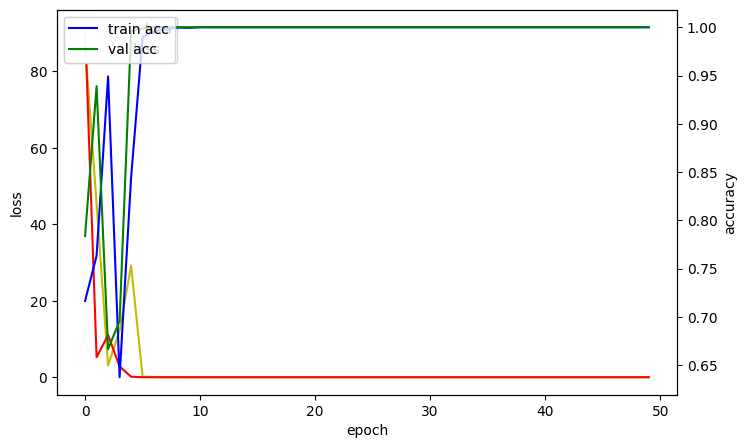

In [29]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(8, 5))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [4]:
import cv2
import mediapipe as mp
import numpy as np
from tensorflow import keras
from keras.models import load_model

actions = ['Next', 'Preview', 'Cam_Off', 'Cam_On']
seq_length = 30

model = load_model('./data/Mini_Project/motion/dataset/models/model.h5')

# MediaPipe hands model (초기화)
mp_hands = mp.solutions.hands
# mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    max_num_hands = 1,
    min_detection_confidence=0.9,
    min_tracking_confidence=0.9)

# 웹캠 열기
cap = cv2.VideoCapture(0)

seq = []
action_seq = []

while cap.isOpened():
    ret, img = cap.read()
    img0 = img.copy()

    img = cv2.flip(img, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    result = hands.process(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if result.multi_hand_landmarks is not None:
        for res in result.multi_hand_landmarks:
            joint = np.zeros((21,4))
            for j, lm in enumerate(res.landmark):
                joint[j] = [lm.x, lm.y, lm.z, lm.visibility]

            # 점들 간의 각도 계산하기
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
            v = v2 - v1 # v2와 v1 사이의 벡터 구하기

            # 점곱을 구한 다음 arccos으로 각도 구하기
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]

            # Get angle using arcos of dot product
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]

            angle = np.degrees(angle) # 라디안을 각도로 바꾸기

            d = np.concatenate([joint.flatten(), angle])


            seq.append(d)

            mp_drawing.draw_landmarks(img, res, mp_hands.HAND_CONNECTIONS)

            if len(seq) < seq_length:
                continue

            input_data = np.expand_dims(np.array(seq[-seq_length:], dtype=np.float32), axis=0)

            # 모델 예측
            y_pred = model.predict(input_data).squeeze()

            # 예측한 값의 인덱스 구하기
            i_pred = int(np.argmax(y_pred))
            conf = y_pred[i_pred]

            # confidence가 0.9보다 작으면
            if conf < 0.99:
                continue # 제스쳐 인식 못 한 상황으로 판단

            action = actions[i_pred]
            action_seq.append(action) # action_seq에 action을 저장
            #print(action_seq)
            # 보인 제스쳐의 횟수가 3 미만인 경우에는 계속
            if len(action_seq) < 3:
                continue
            # 제스쳐 판단 불가이면 this_action은 ?
            this_action = '?'
            # 만약 마지막 3개의 제스쳐가 같으면 제스쳐가 제대로 취해졌다고 판단
            if action_seq[-1] == action_seq[-2] == action_seq[-3]:
                this_action = action
                print(this_action)
            # 텍스트 출력
            cv2.putText(img, f'{this_action.upper()}', org=(int(res.landmark[0].x * img.shape[1]), 
                                                            int(res.landmark[0].y * img.shape[0] + 20)), 
                                                            fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, 
                                                            color=(255, 255, 255), thickness=2)
    # out.write(img0)
    # out2.write(img)
    cv2.imshow('img', img)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 19ms/step
Cam_Off
1/1 [==============================] - 0s 21ms/step
Cam_Off
1/1 [==============================] - 0s 23ms/step
Cam_Off
1/1 [==============================] - 0s 21ms/step
Cam_Off
1/1 [==============================] - 0s 20ms/step
Cam_Off
1/1 [==============================] - 0s 20ms/step
Cam_Off
1/1 [==============================] - 0s 18ms/step
Next
1/1 [==============================] - 0s 19ms/step
Cam_Off
1/1 [==============================] - 0s 20ms/step
Cam_Off
1/1 [==============================] - 0s 19ms/step
Cam_Off
1/1 [==============================] - 0s 19ms/step
Cam_Off
1/1 [==============================] - 0s 18ms/step
Cam_Off
1/1 [==============================] - 0s 20ms/step
Cam_Off
1/1 [==============================] - 0s 18ms/step
Cam_Off
1/1 [==============================] - 0s 19ms/step
Cam_Off
1/1 [==============================] - 0s 18ms/step
Cam_Off
1/1 [==============================] - 0s 2

# 배경변경을 모션으로

In [5]:

# 세그먼트를 위한 YOLOv8 모델 로드
model = YOLO('yolov8n-seg.pt')
# 모션인식을 위한 모델 로드
gesture = load_model('./data/Mini_Project/motion/dataset/models/model.h5')
first_hand_detection = True
# MediaPipe hands model (초기화)
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    max_num_hands = 1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

# 배경을 불러오기
folder_path = './data/background'  # 폴더 경로 설정
file_list = glob.glob(folder_path + '/*')  # 폴더 내의 파일 목록 얻기
file_count = len(file_list)  # 파일 개수 계산
idx = 0 # 파일 리스트를 적절히 초기화해야 함
actions = ['Next', 'Preview', 'Cam_Off', 'Cam_On'] # 모션 인식 레이블
seq_length = 30
seq = []
action_seq = []
# 웹캠을 위한 비디오 캡처 객체 열기
cap = cv2.VideoCapture(0)

first_hand_detection = True


# 비디오 프레임을 반복하여 처리
while cap.isOpened():
    # 비디오에서 프레임 읽기
    success, frame = cap.read()
    hand_frame = frame.copy()
    # ret, img = cap.read()
    # img0 = img.copy()

    # hand_frame = cv2.flip(hand_frame, 1)
    # hand_frame = cv2.cvtColor(hand_frame, cv2.COLOR_BGR2RGB)
    # result = hands.process(img)
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if success:
        # YOLOv8를 사용하여 프레임에 대한 추론 실행
        # classes를 통해 사람만 탐지하도록 설정
        results = model(frame, classes=0, verbose=False)
        handresult = hands.process(hand_frame)
        
        # 검정색 배경 이미지 생성
        background = np.zeros(frame.shape, dtype=np.uint8)
        blackscreen = np.zeros(frame.shape, dtype=np.uint8)
        
        try: # 사람이 탐지되지않으면 오류나는것을 방지
            for result in results:
                # print(result.names) # 탐지 객체 목록 딕셔너리
                # if result.boxes.conf >= 0.80:
                    # print(result.boxes.conf)
                    # if result.probs is not None and result.probs.top1 == 1:
                    for mask in result.masks:
                        # 마스크 데이터에서 차원 축소
                        m = torch.squeeze(mask.data)
                        # 마스크를 RGB 형식으로 변환하여 컴포지트(composite) 텐서 생성
                        composite = torch.stack((m, m, m), 2)
                        # 프레임과 컴포지트를 곱하여 마스크 영역 추출
                        tmp = frame * composite.cpu().numpy().astype(np.uint8)
                        # 추출된 마스크 영역을 배경에 누적
                        # 미리 생성해둔 검은 배경에 세그먼트된 영역을 채워넣음
                        background += tmp
                # else:
                #     # results = model(frame, classes=0)
        except:
            pass
        
        if handresult.multi_hand_landmarks is not None:
            for res in handresult.multi_hand_landmarks:
                joint = np.zeros((21, 4))
                for j, lm in enumerate(res.landmark):
                    joint[j] = [lm.x, lm.y, lm.z, lm.visibility]
                    
            # 점들 간의 각도 계산하기
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
            v = v2 - v1 # v2와 v1 사이의 벡터 구하기

            # 점곱을 구한 다음 arccos으로 각도 구하기
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]
            
            # Get angle using arcos of dot product
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]
            angle = np.degrees(angle) # 라디안을 각도로 바꾸기

            d = np.concatenate([joint.flatten(), angle])

            seq.append(d)
            # mp_drawing.draw_landmarks(frame, res, mp_hands.HAND_CONNECTIONS)

            if len(seq) < seq_length:
                continue
            input_data = np.expand_dims(np.array(seq[-seq_length:], dtype=np.float32), axis=0)
            # 모델 예측
            y_pred = gesture.predict(input_data).squeeze()
            # 예측한 값의 인덱스 구하기
            i_pred = int(np.argmax(y_pred))
            conf = y_pred[i_pred]
            # confidence가 0.9보다 작으면
            if conf < 0.9:
                continue # 제스쳐 인식 못 한 상황으로 판단
            action = actions[i_pred]
            action_seq.append(action) # action_seq에 action을 저장
            #print(action_seq)
            # 보인 제스쳐의 횟수가 3 미만인 경우에는 계속
            if len(action_seq) < 30:
                continue
            # 만약 마지막 3개의 제스쳐가 같으면 제스쳐가 제대로 취해졌다고 판단
            if action_seq[-1] == action_seq[-2] == action_seq[-3]:
                this_action = action
                # # print(this_action)
                if action == 'Next':
                        idx += 1
                        if idx >= len(file_list):
                            idx = 0
                        # time.sleep(0.05)
                elif action == 'Preview':
                        idx -= 1
                        if idx < 0:
                            idx = len(file_list) - 1
                        # time.sleep(0.05)
                # elif action == 'Cam_Off':
                #     background_copy = background
                #     background = bgimg_resized
                # elif action == 'Cam_On':
                    # background = background_copy
            
        # 배경 이미지를 원하는 배경으로 마스킹
        bgimg = cv2.imread(file_list[idx])
        bgimg_resized = cv2.resize(bgimg, (frame.shape[1], frame.shape[0]))
        # 검정색배경에 세그먼트된 영상에서 0인값을 설정해둔 배경으로 마스킹
        background = np.where(background == 0, bgimg_resized, background)
        # background = cv2.resize(background, (960,720))
        background = background.astype(np.uint8)
        # 마스킹된 이미지 출력
        if first_hand_detection:
            if handresult.multi_hand_landmarks is None:
                cv2.imshow("Project", blackscreen)
            else:
                first_hand_detection = False
                cv2.imshow("Project", cv2.flip(background, 1)) # 좌우반전
        else:
            cv2.imshow("Project", cv2.flip(background, 1)) # 좌우반전

        key = cv2.waitKey(1)
            
        # 'q', 'esc', x버튼 키가 눌리면 루프 종료
        if key == 113 or key == 27 or cv2.getWindowProperty('Project', cv2.WND_PROP_VISIBLE) < 1: # ord("q")
            break
        # 'c' 키가 눌리면 다음 배경
        elif key == 99: # ord("c")
            idx += 1
            if idx >= len(file_list):
                idx = 0
        # 'z' 키가 눌리면 이전 배경
        elif key == 122: # ord("z")
            idx -= 1
            if idx < 0:
                idx = len(file_list) - 1

    else:
        # 비디오의 끝에 도달하면 루프 종료
        break

# 비디오 캡처 객체 해제 및 화면 창 닫기
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 18ms/step


In [6]:

# 세그먼트를 위한 YOLOv8 모델 로드
model = YOLO('yolov8n-seg.pt')
# 모션인식을 위한 모델 로드
gesture = load_model('./data/Mini_Project/motion/dataset/models/model.h5')

# MediaPipe hands model (초기화)
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    max_num_hands = 1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

gesture_start = False  # 제스처 인식 시작 여부를 나타내는 변수
gesture_end = False  # 제스처 인식 종료 여부를 나타내는 변수
gesture_duration = 0  # 제스처 인식 지속 시간을 나타내는 변수 (프레임 수)
is_gesture_detected = False  # 제스처 중첩 인식 방지를 위한 변수

# 배경을 불러오기
folder_path = './data/background'  # 폴더 경로 설정
file_list = glob.glob(folder_path + '/*')  # 폴더 내의 파일 목록 얻기
file_count = len(file_list)  # 파일 개수 계산
idx = 0 # 파일 리스트를 적절히 초기화해야 함
actions = ['Next', 'Preview', 'Cam_Off', 'Cam_On'] # 모션 인식 레이블
seq_length = 30
seq = []
action_seq = []
# 웹캠을 위한 비디오 캡처 객체 열기
cap = cv2.VideoCapture(0)

first_hand_detection = True


# 비디오 프레임을 반복하여 처리
while cap.isOpened():
    # start = time.time()
    # 비디오에서 프레임 읽기
    success, frame = cap.read()
    hand_frame = frame.copy()
    hand_frame = cv2.cvtColor(hand_frame, cv2.COLOR_RGB2BGR)
    # ret, img = cap.read()
    # img0 = img.copy()

    # hand_frame = cv2.flip(hand_frame, 1)
    # hand_frame = cv2.cvtColor(hand_frame, cv2.COLOR_BGR2RGB)
    # result = hands.process(img)
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if success:
        # YOLOv8를 사용하여 프레임에 대한 추론 실행
        # classes를 통해 사람만 탐지하도록 설정
        results = model(frame, classes=0, verbose=False)
        handresult = hands.process(hand_frame)
        # handresult = cv
        
        # 검정색 배경 이미지 생성
        background = np.zeros(frame.shape, dtype=np.uint8)
        blackscreen = np.zeros(frame.shape, dtype=np.uint8)
        
        try: # 사람이 탐지되지않으면 오류나는것을 방지
            for result in results:
                # print(result.names) # 탐지 객체 목록 딕셔너리
                # if result.boxes.conf >= 0.80:
                    # print(result.boxes.conf)
                    # if result.probs is not None and result.probs.top1 == 1:
                    for mask in result.masks:
                        # 마스크 데이터에서 차원 축소
                        m = torch.squeeze(mask.data)
                        # 마스크를 RGB 형식으로 변환하여 컴포지트(composite) 텐서 생성
                        composite = torch.stack((m, m, m), 2)
                        # 프레임과 컴포지트를 곱하여 마스크 영역 추출
                        tmp = frame * composite.cpu().numpy().astype(np.uint8)
                        # 추출된 마스크 영역을 배경에 누적
                        # 미리 생성해둔 검은 배경에 세그먼트된 영역을 채워넣음
                        background += tmp
                # else:
                #     # results = model(frame, classes=0)
        except:
            pass
        
        if handresult.multi_hand_landmarks is not None:
            for res in handresult.multi_hand_landmarks:
                joint = np.zeros((21, 4))
                for j, lm in enumerate(res.landmark):
                    joint[j] = [lm.x, lm.y, lm.z, lm.visibility]
                    
            # 점들 간의 각도 계산하기
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
            v = v2 - v1 # v2와 v1 사이의 벡터 구하기

            # 점곱을 구한 다음 arccos으로 각도 구하기
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]
            
            # Get angle using arcos of dot product
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]
            angle = np.degrees(angle) # 라디안을 각도로 바꾸기

            d = np.concatenate([joint.flatten(), angle])

            seq.append(d)
            # mp_drawing.draw_landmarks(frame, res, mp_hands.HAND_CONNECTIONS)

            if len(seq) < seq_length:
                continue
            input_data = np.expand_dims(np.array(seq[-seq_length:], dtype=np.float32), axis=0)
            # 모델 예측
            y_pred = gesture.predict(input_data).squeeze()
            # 예측한 값의 인덱스 구하기
            i_pred = int(np.argmax(y_pred))
            conf = y_pred[i_pred]
            # confidence가 0.9보다 작으면
            if conf < 0.7:
                continue # 제스쳐 인식 못 한 상황으로 판단
            action = actions[i_pred]
            action_seq.append(action) # action_seq에 action을 저장
            #print(action_seq)
            # 보인 제스쳐의 횟수가 3 미만인 경우에는 계속
            if len(action_seq) < 3:
                continue
            # 만약 마지막 3개의 제스쳐가 같으면 제스쳐가 제대로 취해졌다고 판단
            if action_seq[-1] == action_seq[-2] == action_seq[-3]:
                this_action = action
                # # print(this_action)
                if action == 'Next':
                    if not is_gesture_detected:  # 중첩 인식 방지 변수 확인
                        idx += 1
                        if idx >= len(file_list):
                            idx = 0
                        is_gesture_detected = True  # 중첩 인식 방지 변수 설정
                elif action == 'Preview':
                    if not is_gesture_detected:  # 중첩 인식 방지 변수 확인
                        idx -= 1
                        if idx < 0:
                            idx = len(file_list) - 1
                        is_gesture_detected = True  # 중첩 인식 방지 변수 설정
                elif action == 'Cam_off':
                    cv2.imshow("Project", blackscreen)
                    is_gesture_detected = True  # 중첩 인식 방지 변수 설정
                elif action == 'cam_On':
                    cv2.imshow("Project", cv2.flip(background, 1)) # 좌우반전
                    is_gesture_detected = True  # 중첩 인식 방지 변수 설정
                else:
                    gesture_start = False  # 제스처 인식 시작 여부를 나타내는 변수
                    gesture_end = False  # 제스처 인식 종료 여부를 나타내는 변수
                    gesture_duration = 0  # 제스처 인식 지속 시간을 나타내는 변수 (프레임 수)
                    is_gesture_detected = False  # 제스처 중첩 인식 방지를 위한 변수
                # elif action == 'Cam_Off':
                #     background_copy = background
                #     background = bgimg_resized
                # elif action == 'Cam_On':
                    # background = background_copy
            
        # 배경 이미지를 원하는 배경으로 마스킹
        bgimg = cv2.imread(file_list[idx])
        bgimg_resized = cv2.resize(bgimg, (frame.shape[1], frame.shape[0]))
        # 검정색배경에 세그먼트된 영상에서 0인값을 설정해둔 배경으로 마스킹
        background = np.where(background == 0, bgimg_resized, background)
        # background = cv2.resize(background, (960,720))
        background = background.astype(np.uint8)
        # 마스킹된 이미지 출력
        if first_hand_detection:
            if handresult.multi_hand_landmarks is None:
                cv2.imshow("Project", blackscreen)
            else:
                first_hand_detection = False
                cv2.imshow("Project", cv2.flip(background, 1)) # 좌우반전
        else:
            cv2.imshow("Project", cv2.flip(background, 1)) # 좌우반전

        key = cv2.waitKey(1)
        # 'q', 'esc', x버튼 키가 눌리면 루프 종료
        if key == 113 or key == 27 or cv2.getWindowProperty('Project', cv2.WND_PROP_VISIBLE) < 1: # ord("q")
            break
        # 'c' 키가 눌리면 다음 배경
        elif key == 99: # ord("c")
            idx += 1
            if idx >= len(file_list):
                idx = 0
        # 'z' 키가 눌리면 이전 배경
        elif key == 122: # ord("z")
            idx -= 1
            if idx < 0:
                idx = len(file_list) - 1
        # end = time.time()
        # print(end - start)
    else:
        # 비디오의 끝에 도달하면 루프 종료
        break

# 비디오 캡처 객체 해제 및 화면 창 닫기
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 18ms/step


In [8]:
import glob
def get_Background_Image_list(path):
    file_list = glob.glob(path + '/*') # 전달받은 폴더 경로로부터 파일 목록을 가져옴
    file_count = len(file_list) # 파일 개수 계산
    # idx = 0 # 파일 리스트에서 사용할 인덱스번호 초기화
    print(f'폴더 내 파일 개수 : {file_count}') # 폴더내의 파일 개수 확인
    return file_list

In [9]:
import cv2
def Background_Image_load(file_list, idx, frame):
    bgimg = cv2.imread(file_list[idx]) # 파일리스트에서 idx번호의 파일 이미지를 불러옴
    bgimg_resized = cv2.resize(bgimg, (frame.shape[1], frame.shape[0])) # 불러온 이미지를 frame사이즈와 같게 리사이즈
    return bgimg_resized

In [18]:
def key_and_action(key, action):
    # 'q', 'esc', x버튼 키가 눌리면 루프 종료
        if key == 113 or key == 27 or cv2.getWindowProperty('Project', cv2.WND_PROP_VISIBLE) < 1: # ord("q")
            return 'Exit'
        # 'c' 키가 눌리면 다음 배경
        elif key == 99 or action == 'Next': # ord("c")
            return 'Next'
        # 'z' 키가 눌리면 이전 배경
        elif key == 122 or action == 'Preview': # ord("z")
            return 'Preview'
        else:
            return 'Continue'

In [12]:
from ultralytics import YOLO
import cv2
import torch
import numpy as np
import glob
import pandas as pd
from tensorflow import keras
from keras.models import load_model
import mediapipe as mp
import time

In [10]:
# global idx
# 세그먼트를 위한 YOLOv8 모델 로드
model = YOLO('yolov8n-seg.pt')
# 모션인식을 위한 모델 로드
gesture = load_model('./data/Mini_Project/motion/dataset/models/model.h5')

# MediaPipe hands model (초기화)
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    max_num_hands = 1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5)

# 배경을 불러오기
folder_path = './data/background'  # 폴더 경로 설정
idx = 0 
file_list = get_Background_Image_list(folder_path) # 폴더 경로를 입력받아 폴더 내의 파일 리스트를 받아옴
# file_list = glob.glob(folder_path + '/*')  # 폴더 내의 파일 목록 얻기
# file_count = len(file_list)  # 파일 개수 계산
# idx = 0 # 파일 리스트를 적절히 초기화해야 함
actions = ['Next', 'Preview', 'Cam_Off', 'Cam_On'] # 모션 인식 레이블
seq = []
action_seq = []
# 웹캠을 위한 비디오 캡처 객체 열기
cap = cv2.VideoCapture(0)
start = time.time()
# 비디오 프레임을 반복하여 처리
while cap.isOpened():
    # 비디오에서 프레임 읽기
    success, frame = cap.read()

    if success:
        # YOLOv8를 사용하여 프레임에 대한 추론 실행
        # classes를 통해 사람만 탐지하도록 설정
        results = model(frame, classes=0, verbose=False)
        # 검정색 배경 이미지 생성
        background = np.zeros(frame.shape, dtype=np.uint8)
        
        try: # 사람이 탐지되지않으면 오류나는것을 방지
            for result in results:
                # print(result.names) # 탐지 객체 목록 딕셔너리
                # if result.boxes.conf >= 0.80:
                    # print(result.boxes.conf)
                    # if result.probs is not None and result.probs.top1 == 1:
                    for mask in result.masks:
                        # 마스크 데이터에서 차원 축소
                        m = torch.squeeze(mask.data)
                        # 마스크를 RGB 형식으로 변환하여 컴포지트(composite) 텐서 생성
                        composite = torch.stack((m, m, m), 2)
                        # 프레임과 컴포지트를 곱하여 마스크 영역 추출
                        tmp = frame * composite.cpu().numpy().astype(np.uint8)
                        # 추출된 마스크 영역을 배경에 누적
                        # 미리 생성해둔 검은 배경에 세그먼트된 영역을 채워넣음
                        background += tmp
                # else:
                #     # results = model(frame, classes=0)

        except:
            pass

        handresult = hands.process(frame)
        
        if handresult.multi_hand_landmarks is not None:
            for res in handresult.multi_hand_landmarks:
                joint = np.zeros((21, 4))
                for j, lm in enumerate(res.landmark):
                    joint[j] = [lm.x, lm.y, lm.z, lm.visibility]
                    
            # 점들 간의 각도 계산하기
            v1 = joint[[0,1,2,3,0,5,6,7,0,9,10,11,0,13,14,15,0,17,18,19], :3] # Parent joint
            v2 = joint[[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], :3] # Child joint
            v = v2 - v1 # v2와 v1 사이의 벡터 구하기

            # 점곱을 구한 다음 arccos으로 각도 구하기
            v = v / np.linalg.norm(v, axis=1)[:, np.newaxis]
            
            # Get angle using arcos of dot product
            angle = np.arccos(np.einsum('nt,nt->n',
                v[[0,1,2,4,5,6,8,9,10,12,13,14,16,17,18],:], 
                v[[1,2,3,5,6,7,9,10,11,13,14,15,17,18,19],:])) # [15,]
            angle = np.degrees(angle) # 라디안을 각도로 바꾸기

            d = np.concatenate([joint.flatten(), angle])

            seq.append(d)
            mp_drawing.draw_landmarks(frame, res, mp_hands.HAND_CONNECTIONS)

            if len(seq) < seq_length:
                continue
            input_data = np.expand_dims(np.array(seq[-seq_length:], dtype=np.float32), axis=0)
            # 모델 예측
            y_pred = gesture.predict(input_data).squeeze()
            # 예측한 값의 인덱스 구하기
            i_pred = int(np.argmax(y_pred))
            conf = y_pred[i_pred]
            # confidence가 0.9보다 작으면
            if conf < 0.9:
                continue # 제스쳐 인식 못 한 상황으로 판단
            action = actions[i_pred]
            action_seq.append(action) # action_seq에 action을 저장
            #print(action_seq)
            # 보인 제스쳐의 횟수가 3 미만인 경우에는 계속
            if len(action_seq) < 3:
                continue
            # 만약 마지막 3개의 제스쳐가 같으면 제스쳐가 제대로 취해졌다고 판단
            if action_seq[-1] == action_seq[-2] == action_seq[-3]:
                this_action = action
                # # print(this_action)
                # if action == 'Next':
                #         idx += 1
                #         if idx >= len(file_list):
                #             idx = 0
                #         # time.sleep(0.3)
                # elif action == 'Preview':
                #         idx -= 1
                #         if idx < 0:
                #             idx = len(file_list) - 1
                            # time.sleep(0.3)
                # elif action == 'Cam_Off':
                #     background_copy = background
                #     background = bgimg_resized
                # elif action == 'Cam_On':
                    # background = background_copy
            
        # 배경 이미지를 원하는 배경으로 마스킹
        bgimg_resized = Background_Image_load(file_list, idx, frame) # 인덱스 번호에 맞는 배경 이미지를 frame과 같은 사이즈로 조정해 반환
        # bgimg = cv2.imread(file_list[idx])
        # bgimg_resized = cv2.resize(bgimg, (frame.shape[1], frame.shape[0]))
        # 검정색배경에 세그먼트된 영상에서 0인값을 설정해둔 배경으로 마스킹
        background = np.where(background == 0, bgimg_resized, background)
        # background = cv2.resize(background, (960,720))
        background = background.astype(np.uint8)
        # 마스킹된 이미지 출력
        cv2.imshow("Project", cv2.flip(background, 1)) # 좌우반전

        key = cv2.waitKey(1)
        action = 'continue'
        input_command = key_and_action(key, action) # key값과 action값에 따라 명령 할당
        if input_command == 'Exit':
            break
        elif input_command == 'Next':
            idx += 1
            if idx >= len(file_list):
                idx = 0
        elif input_command == 'Preview':
            idx -= 1
            if idx < 0:
                idx = len(file_list) - 1
            
        # # 'q', 'esc', x버튼 키가 눌리면 루프 종료
        # if key == 113 or key == 27 or cv2.getWindowProperty('Project', cv2.WND_PROP_VISIBLE) < 1: # ord("q")
        #     break
        # # 'c' 키가 눌리면 다음 배경
        # elif key == 99: # ord("c")
        #     idx += 1
        #     if idx >= len(file_list):
        #         idx = 0
        # # 'z' 키가 눌리면 이전 배경
        # elif key == 122: # ord("z")
        #     idx -= 1
        #     if idx < 0:
        #         idx = len(file_list) - 1
        end = time.time()
        print(start - end)
    else:
        # 비디오의 끝에 도달하면 루프 종료
        break

# 비디오 캡처 객체 해제 및 화면 창 닫기
cap.release()
cv2.destroyAllWindows()

NameError: name 'get_Background_Image_list' is not defined